In [1]:
import ujson

with open('user_project_summaries.json') as o:
    summaries = ujson.load(o)

## Project names

### Morphological analysis

Use a morphological analyzer to learn to split project names.

In [2]:
with open('projectnames.txt', 'w') as o:
    for userid in summaries:
        for projectid in summaries[userid]:
            o.write(summaries[userid][projectid]['**Project Name']+' ')

In [3]:
import morfessor
io = morfessor.MorfessorIO()
train_data = io.read_corpus_file('projectnames.txt')
model_tokens = morfessor.BaselineModel()
model_tokens.load_data(train_data)
model_tokens.train_batch()

...........................................................
...........................................................
...........................................................
...........................................................
...........................................................
...........................................................
...........................................................


(7, 900895.6888010611)

In [4]:
pnames = open('projectnames.txt').read().split()

In [5]:
segpnames = [model_tokens.viterbi_segment(word) for word in pnames]

In [6]:
for segpname, _ in segpnames[:50]:
    print segpname,

['Phone', 'AccessLab'] ['BtCarEmuLab'] ['BN103096', 'Voice', 'Dict'] ['BN103096', 'Mole'] ['BN103096', 'L', 'AP', '01'] ['BN103096', 'Lab', '03', '05'] ['BtOX', 'Game', 'Lab', 'V1'] ['Screen', '4'] ['BN103', '09', '7', 'EX05', '07', '02'] ['BN103096', 'T2', 'S'] ['BN103096', '1'] ['BN103', '2', '99', 'Lab', '03', '05'] ['Block', '_', 'Lab', '00'] ['BN103096'] ['BN103096', 'OddEven'] ['BN103096', 'ST', 'ER'] ['BN103096', 'AA', '01'] ['BN103096', 'Sensor', '1'] ['BN103', '02', 'MD', '01'] ['BN103096', 'EX05', '07', '02'] ['BN103', '02', 'MD', '03'] ['WebViewer', 'Lab'] ['Lotto', '1111', 'Lab'] ['BN103096', 'Ex040901', '09', '02'] ['Web', 'AccessLab'] ['BN103', '2', '99', 'Roll', 'er', '2'] ['MusicPlayer', '2', 'Lab'] ['BN103096', 'BN103', '100'] ['Bluetooth', 'Lab1'] ['BN103096', 'Click'] ['BN103096', 'Demo', '01'] ['Lab', '00'] ['BN103096', 'Ex05', '07', '01'] ['BN103096', 'game', 'ox'] ['bn103096', 'clock'] ['BN103096', '_', 'MusicPlayer', 'Lab'] ['BN103096', 'Ex05', '07', '02'] ['BtCa

Does this give anything reasonable? Remains to be explored. Might need some parameter tweaking.

### Clustering

Cluster the project names using edit distance.

In [7]:
import leven
from sklearn.cluster import AffinityPropagation
import numpy as np

pnameset = list(set(pnames))[:7000]   # will increase, but clustering takes longer

lev_aff = np.zeros((len(pnameset), len(pnameset)))
for i, pnamei in enumerate(pnameset):
    if i%100==0:
        print '.',
    for j, pnamej in enumerate(pnameset):
        if j>i:
            lev_aff[i, j] = -1*leven.levenshtein(pnamei, pnamej)
        elif j==i:
            lev_aff[i, j] = 0
        else:
            lev_aff[i, j] = lev_aff[j, i]
print 'Computed pairwise edit distances'

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Computed pairwise edit distances


In [8]:
model = AffinityPropagation(affinity="precomputed")
model.fit(lev_aff)
print 'Fit affinity propagator'

Fit affinity propagator


In [9]:
from collections import defaultdict
exemplars = defaultdict(list)
for i, clustid in enumerate(model.labels_):
    exem = model.cluster_centers_indices_[clustid]
    exemplars[pnameset[exem]].append(pnameset[i])
    
# look at a sample
for exem in exemplars.keys()[:10]:
    print exem, exemplars[exem]

MyActivitySiwni ['ActivityRecord', 'MyActivityMETHULI', 'MyActivityvihan__4226', 'MyActivitymethuli', 'MyActivitySiwni']
Lab1_Combine_Instrument_copy ['Lab1_Combine_Instrument_copy']
BluetoothConnection6 ['BluetoothConnection3', 'BluetoothConnection6', 'BluetoothConnection7', 'BluetoothConnection4', 'BluetoothConnection9', 'bluetoothforarduino_app', 'bluetoothClient_Ardino', 'Midterm2Corrections', 'BluetoothConnectionWhatakuai', 'Blutooth_Jonathanlois']
ALLGTAGRANDTHEFTAUTOFULLANDROIDPORTS ['ALLGTAGRANDTHEFTAUTOFULLANDROIDPORTS']
MileyBash_NeedsDebugging ['MileyBash_Debugged1', 'MileyBash_NeedsDebugging']
Project_AlainS_GuessTheName_copy ['Project_AlainS_GuessTheName_copy']
get_location ['test_leehwanung', 'Math_Addition', 'sprite_rotation', 'DreamWorkExpansion', 'FBI_Locator', 'Notification', 'Horacio_Jonathan', 'p10B_velocidad_luz', 'Ch7_Location', 'MapMyLocation', 'get_location', 'Newton_Raphson', 'ex_calculation', 'App_Test_Socrative']
Chapter12 ['Chapter11_S', 'Chapter11_C', 'CWCh

Unclear whether these clusters are meaningful, BUT we can very that later by looking at the code.

## Language Identification from Project and Variable Names

Predict the native language of a user from their project/variable names and strings.

In [10]:
import langid

user_tokens = defaultdict(list)
for userid in summaries:
    for projectid in summaries[userid]:
        numscreens = summaries[userid][projectid]['*Number of Screens']
        for screenid in range(numscreens):
            screentitle = 'Screen'+str(screenid+1)
            if screentitle in summaries[userid][projectid]:
                # blocks
                if summaries[userid][projectid][screentitle]['Blocks']=='NO BLOCKS':
                    continue
                blocks = summaries[userid][projectid][screentitle]['Blocks']
                if blocks['Active Blocks']=='NO ACTIVE BLOCKS':
                    continue
                for namesp in ['Global Variable Names', 'Procedure Names', 'Procedure Parameter Names', 'Strings']:
                    for vname in blocks['Active Blocks'][namesp]:
                        user_tokens[userid].append(vname)
                # components
                if summaries[userid][projectid][screentitle]['Components']=='N':
                    continue
                for sname in summaries[userid][projectid][screentitle]['Components']['Strings']:
                    user_tokens[userid].append(sname)
            

In [16]:
from collections import defaultdict, Counter

user_langs = defaultdict(lambda : defaultdict(float))
for userid in user_tokens:
    if len(user_tokens[userid])<50:
        print '.',
        continue
    user_langs[userid] = langid.classify(' '.join(user_tokens[userid]))[0]

with open('user_inferredlangs.json', 'w') as o:
    ujson.dump(user_langs, o)

. . . . . . . . . . . . . . . . . . . .


972 total users


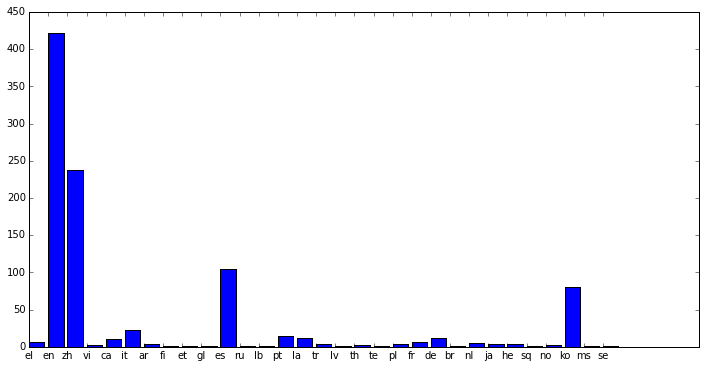

In [23]:
langcounts = Counter(user_langs.values())

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
matplotlib.rcParams['figure.figsize'] = (12, 6)

plt.bar(range(len(langcounts)), langcounts.values())
plt.xticks(range(len(langcounts)), langcounts.keys())

print sum(langcounts.values()), 'total users'